<a href="https://colab.research.google.com/github/MrSh4d0w/Deep-Learning/blob/main/Red_neuronal_TensorFlow_y_Keras_(animales).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importamos las librerías correspondientes y el material para la red.


Librerías

In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

Imágenes de Perros y Gatos

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2021-10-28 12:51:29--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   141MB/s    in 0.5s    

2021-10-28 12:51:30 (141 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



Creación de directorios de perros y gatos

In [ ]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Importamos el modelo InceptionV3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3


Hacemos uso de todas las capas del modelo excepto la última capa densa (totalmente conectada)

In [ ]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

87924736/87910968 [==============================] - 1s 0us/step


*Hacemos* que las capas no sean entrenables (podemos dejar alguna más para entrenar nosotros, pero tenemos que tener cuidado con el overfitting)



In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False

Vemos la red que tenemos

In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

# Entrenamos el modelo

Definimos un callback si el accuracy supera el 95%

In [ ]:

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

# Entrenamos la red

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)

model = Model( pre_trained_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.0001),  #Usamos RMSprop para el learningrate: tambien podemos usar Adam o Adagrad
              loss = 'binary_crossentropy',  #Usamnos binary_crossentropy porque tenemos 2 clases a predecir (perros y gatos)
              metrics = ['acc'])

Data augmentation:

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary',
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Entreno de la red:

In [ ]:

callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_steps = 50,
            verbose = 2,
            callbacks=[callbacks])

Epoch 1/100
100/100 - 156s - loss: 0.7452 - acc: 0.8695 - val_loss: 0.1577 - val_acc: 0.9500
Epoch 2/100
100/100 - 155s - loss: 0.4420 - acc: 0.8900 - val_loss: 0.1917 - val_acc: 0.9370
Epoch 3/100
100/100 - 150s - loss: 0.3482 - acc: 0.9005 - val_loss: 0.5033 - val_acc: 0.8900
Epoch 4/100
100/100 - 149s - loss: 0.3167 - acc: 0.9045 - val_loss: 0.2354 - val_acc: 0.9520
Epoch 5/100
100/100 - 148s - loss: 0.3935 - acc: 0.9160 - val_loss: 0.3061 - val_acc: 0.9330
Epoch 6/100
100/100 - 146s - loss: 0.3166 - acc: 0.9235 - val_loss: 0.4387 - val_acc: 0.9150
Epoch 7/100
100/100 - 147s - loss: 0.2612 - acc: 0.9270 - val_loss: 0.2003 - val_acc: 0.9540
Epoch 8/100
100/100 - 147s - loss: 0.3030 - acc: 0.9185 - val_loss: 0.1716 - val_acc: 0.9590
Epoch 9/100
100/100 - 148s - loss: 0.2967 - acc: 0.9305 - val_loss: 0.1547 - val_acc: 0.9650
Epoch 10/100
100/100 - 146s - loss: 0.2981 - acc: 0.9190 - val_loss: 0.2061 - val_acc: 0.9510
Epoch 11/100
100/100 - 147s - loss: 0.2880 - acc: 0.9300 - val_loss: 

Representación en una gráfica de las métricas relevantes

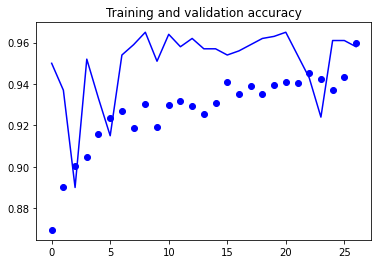

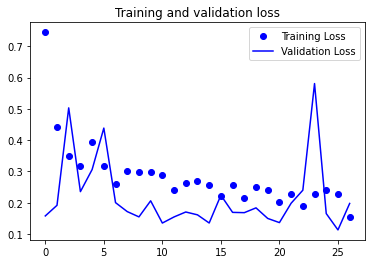

In [ ]:

import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Uso del modelo para predecir imágenes

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)